In [1]:
import numpy as np
import pandas as pd
from utils.model_training import prepare_model_features, visualize_features
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv(
    "./data/processed/stop-and-frisk.csv",
    parse_dates=["STOP_FRISK_DATE"],  
)
# df.info()

In [3]:
X, y = prepare_model_features(df)
assert not X.isnull().any().any(), "Null values remain in features"

In [4]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Train distribution:", y_train.value_counts(normalize=True), "\n")
print("Test distribution:", y_test.value_counts(normalize=True))

Train distribution: OFFICER_USED_FORCE
False    0.748507
True     0.251493
Name: proportion, dtype: float64 

Test distribution: OFFICER_USED_FORCE
False    0.748501
True     0.251499
Name: proportion, dtype: float64


[[4928 3313]
 [1090 1679]]
              precision    recall  f1-score   support

       False       0.82      0.60      0.69      8241
        True       0.34      0.61      0.43      2769

    accuracy                           0.60     11010
   macro avg       0.58      0.60      0.56     11010
weighted avg       0.70      0.60      0.63     11010



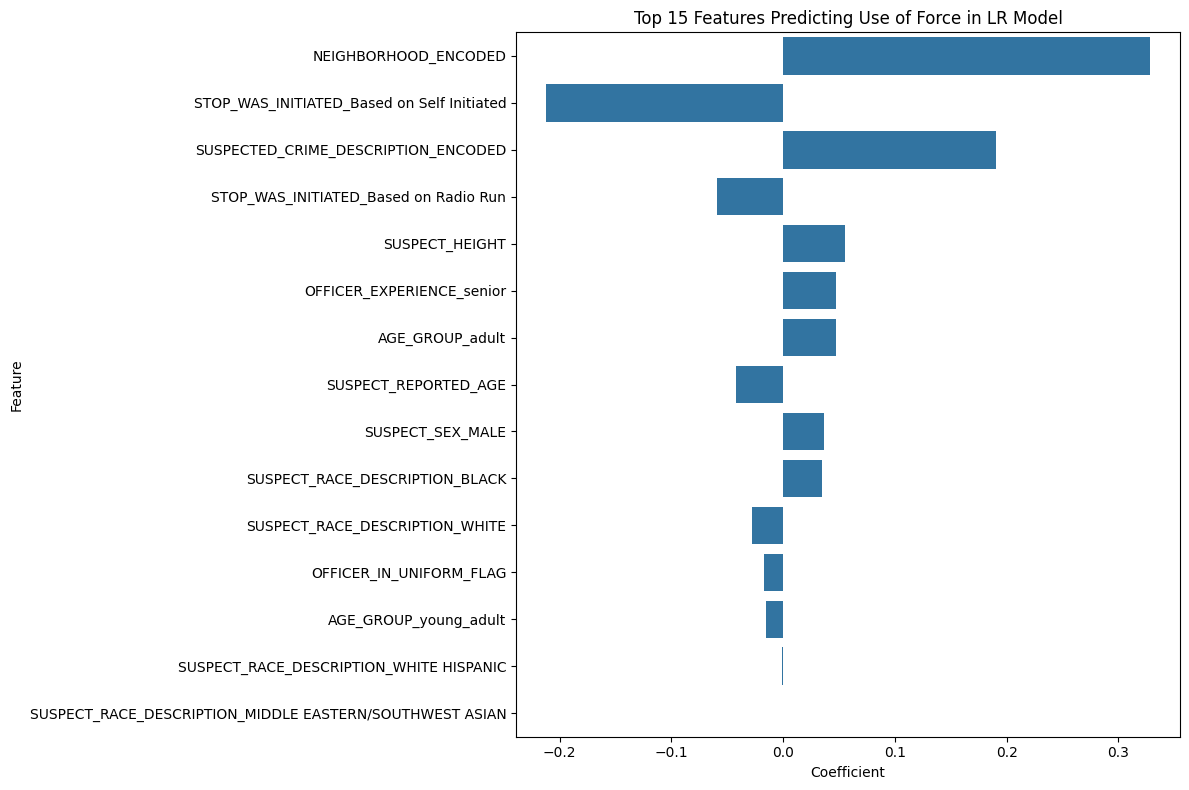

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Standardize features for quicker training...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, C= 0.01, penalty= 'l1', solver= 'liblinear')
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
visualize_features(X,lr_model, "Top 15 Features Predicting Use of Force in LR Model")


Best params: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best recall: 0.4325526608173938
[[4538 3703]
 [ 956 1813]]
              precision    recall  f1-score   support

       False       0.83      0.55      0.66      8241
        True       0.33      0.65      0.44      2769

    accuracy                           0.58     11010
   macro avg       0.58      0.60      0.55     11010
weighted avg       0.70      0.58      0.60     11010



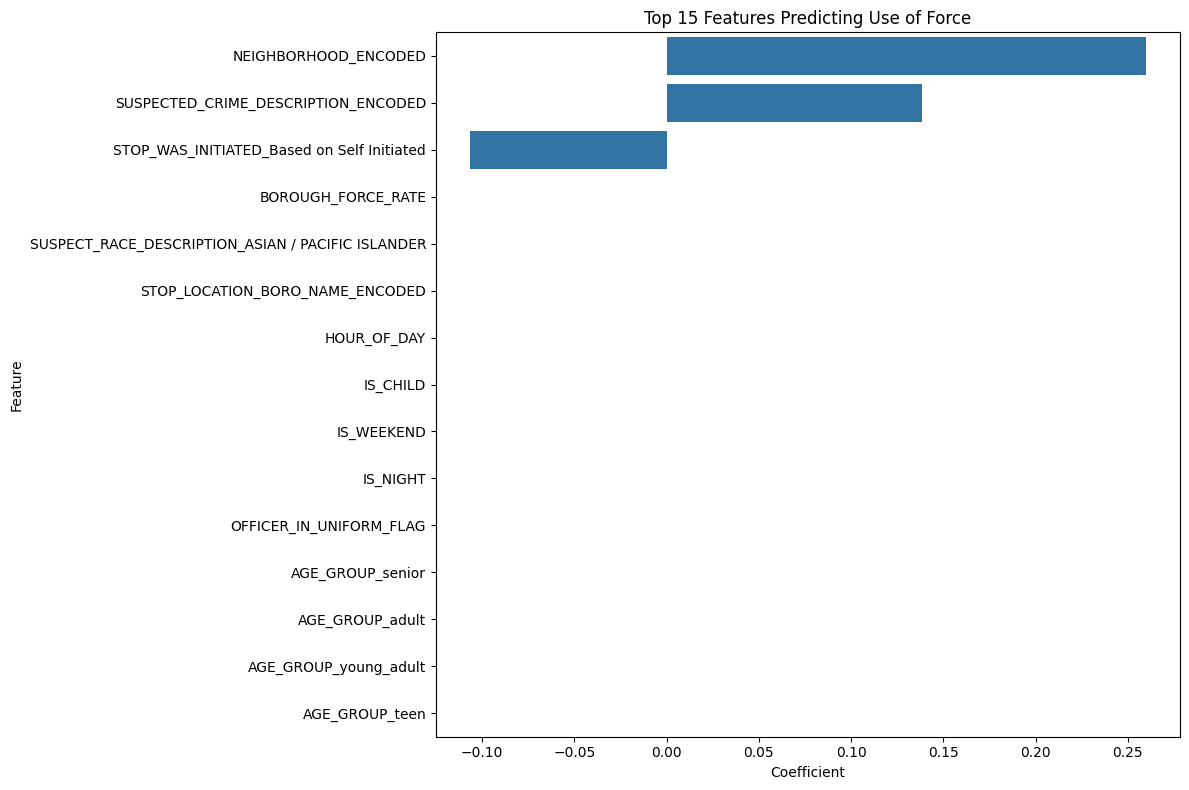

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse regularization strength
    'penalty': ['l1', 'l2'],           # Regularization type
    'solver': ['liblinear', 'saga']     # Solvers that support L1
}

grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='recall',  # Prioritize catching true positives
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best recall:", grid.best_score_)

y_pred = grid.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
visualize_features(X,grid.best_estimator_)
